# Model Selection and Hyperparameter Tuning

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from matplotlib import pyplot as plt

In [2]:
training_data_wt = pd.read_csv('Nata_Files/less_features/train_data_lf.csv', index_col=0)
testing_data_wt = pd.read_csv('Nata_Files/less_features/test_data_lf.csv', index_col=0)
prediction_data = pd.read_csv('Nata_Files/less_features/pred_data_lf.csv', index_col=0)
learn = pd.read_csv('Nata_Files/learn.csv', index_col=0)
learn.isna().sum()

ambient_humidity       18
baking_duration         1
cooling_period          1
cream_fat_content      24
egg_temperature        24
egg_yolk_count         24
final_temperature      25
lemon_zest_ph          26
notes_baker          5200
origin                161
oven_temperature       21
pastry_type          1789
preheating_time        19
salt_ratio             13
sugar_content          22
vanilla_extract        18
quality_class           1
dtype: int64

In [3]:
X_train = training_data_wt.drop('target', axis=1)
y_train = training_data_wt['target']
X_test = testing_data_wt.drop('target', axis=1)
y_test = testing_data_wt['target']

In [4]:
dtc = DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)
logreg = LogisticRegression(solver='sag', multi_class='ovr')
knn = KNeighborsClassifier(n_neighbors=10)
bag=BaggingClassifier(max_samples=0.2,estimator=knn, random_state=42, bootstrap=False)

In [143]:
bag.score(X_test, y_test)

0.7361538461538462

In [144]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

In [146]:
def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = rskf)
    return n_scores

In [183]:
def return_results(models, X = X, y = y):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels= names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

In [5]:
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score
)

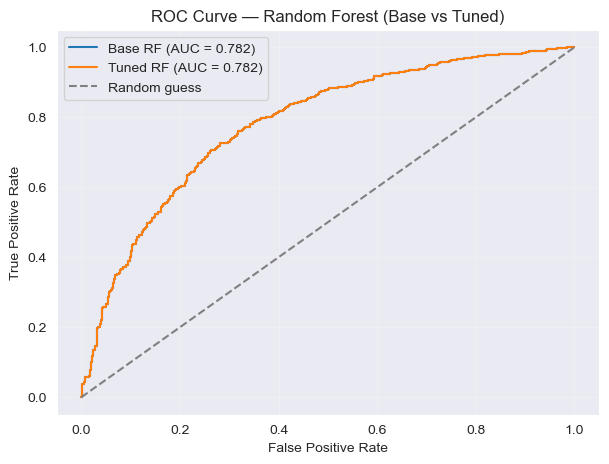

In [166]:
y_train_bin = y_train.map({'OK': 1, 'KO': 0})
y_test_bin  = y_test.map({'OK': 1, 'KO': 0})

y_proba_rf_base = logreg.predict_proba(X_test)[:, 1]
y_proba_rf_tuned = logreg.predict_proba(X_test)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test_bin, y_proba_rf_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_bin, y_proba_rf_tuned)

auc_base = roc_auc_score(y_test_bin, y_proba_rf_base)
auc_tuned = roc_auc_score(y_test_bin, y_proba_rf_tuned)

plt.figure(figsize=(7, 5))
plt.plot(fpr_base, tpr_base, label=f'Base RF (AUC = {auc_base:.3f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RF (AUC = {auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (Base vs Tuned)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

>True 0.782 (0.016)
>False 0.746 (0.018)


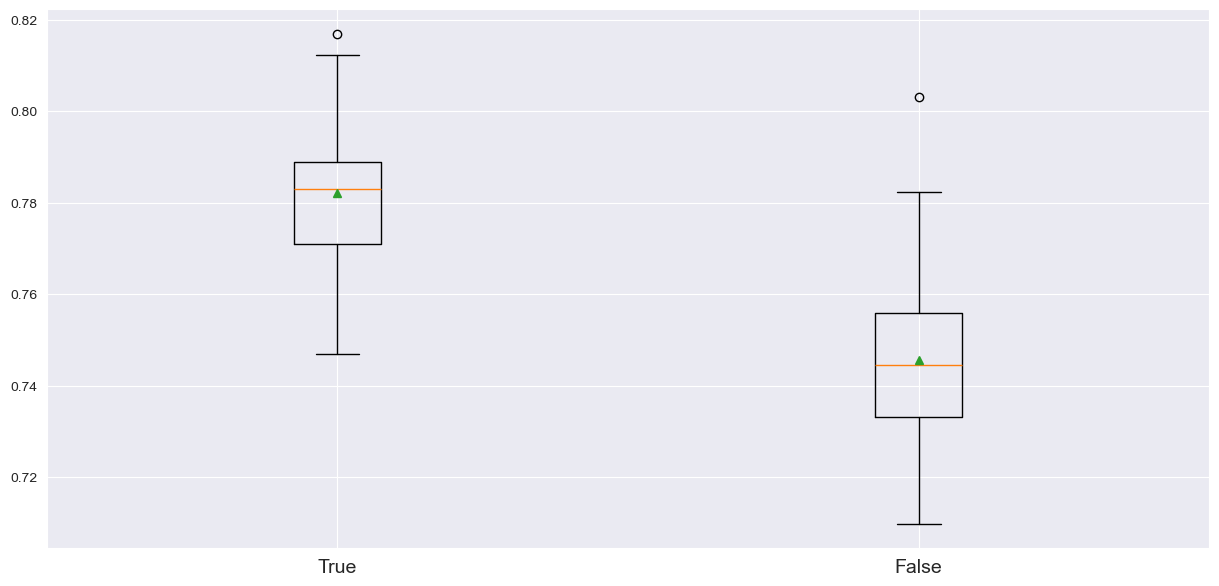

In [171]:
def get_models(values):
    '''Creates a dict of models where the bool value for drawing samples with replacement (True or False) is equal to value.
    The number of models created will be equal to the lenght of vector values'''
    models = dict()
    for value in values:
        models[str(value)] = BaggingClassifier(bootstrap = value, random_state = 5)
    return models

models = get_models([True, False])
return_results(models)

In [6]:
models = [knn, logreg, dtc, bag]
y_df = []
for model in models:
    model.fit(X_train, y_train)
    y_df.append(model.predict(X_train))

In [123]:
y_df

[array(['OK', 'OK', 'OK', ..., 'OK', 'KO', 'OK'], dtype=object),
 array(['OK', 'OK', 'OK', ..., 'OK', 'KO', 'OK'], dtype=object),
 array(['OK', 'OK', 'OK', ..., 'KO', 'KO', 'OK'], dtype=object),
 array(['OK', 'OK', 'OK', ..., 'OK', 'KO', 'OK'], dtype=object)]

In [62]:
df_y = np.array(y_df).T

In [111]:
[row.reshape(-1,1) for row in pd.get_dummies(y_train, dtype=int).to_numpy()]


[array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[1],
        [0]]),
 array([[0],
        [1]]),
 array([[0],
        [1]]),
 array([[0],
       

In [229]:
y_df = pd.DataFrame(np.array(y_df).T, columns=['knn','logreg','dtc','bag'])
backup = y_df.copy

In [245]:
logreg.fit(y_df, y_train)
logreg.score(y_df, y_train)

0.860668380462725

In [159]:
estimators = [('knn', knn), ('logreg', logreg), ('dtc', dtc), ('bag', bag)]

In [243]:
stack = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression()).fit(X_train,y_train)

In [244]:
stack.score(X_train, y_train), stack.score(X_test, y_test)

(0.8264781491002571, 0.7638461538461538)

In [9]:
class Sigmoid:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim)
        self.bias = np.zeros((output_dim, 1))
        self.input = None
        self.arr_Z = None

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        output = self.sigmoid(x)
        return output * (1 - output)

    def forward(self, input):
        self.input = input
        self.arr_Z = np.dot(self.weights.transpose(), self.input) + self.bias
        return self.sigmoid(self.arr_Z)

    def backward(self, delta_from_next_layer, learning_rate):
        del_Z = delta_from_next_layer * self.sigmoid_derivative(self.arr_Z)
        dB = np.sum(del_Z, axis=1, keepdims=True)
        dW_for_update = np.dot(self.input, del_Z.transpose())
        self.weights -= learning_rate * dW_for_update
        self.bias -= learning_rate * dB
        error_to_previous_layer = np.dot(self.weights, del_Z)
        return error_to_previous_layer

class SoftMAX:
    def __init__(self, input_dim, output_dim):
        self.weights = np.random.randn(input_dim, output_dim)
        self.bias = np.zeros((output_dim, 1))
        self.input = None
        self.arr_Z = None

    def softmax(self, x):
        arr = []
        for val in x:
            arr.append([np.exp(val) / np.sum(np.exp(x))])
        return np.array(arr).reshape(2, 1)

    def softmax_derivative(self, x):
        output = self.softmax(x)
        return output * (1 - output)

    def forward(self, input):
        self.input = input
        self.arr_Z = np.dot(self.weights.transpose(), self.input) + self.bias
        return self.softmax(self.arr_Z)

    def backward(self, delta_from_next_layer, learning_rate):
        del_Z = delta_from_next_layer * self.softmax_derivative(self.arr_Z)
        dB = np.sum(del_Z, axis=1, keepdims=True)
        dW_for_update = np.dot(self.input, del_Z.transpose())
        self.weights -= learning_rate * dW_for_update
        self.bias -= learning_rate * dB
        error_to_previous_layer = np.dot(self.weights, del_Z)
        return error_to_previous_layer

In [111]:
class Trinity:
    def __init__(self, size):
        """
        Binary classification network (OK/KO) for binary input vectors

        Args:
            size: dimension of input vector (number of binary features)
        """
        self.del_in = None
        self.del_out = None
        # For binary inputs, we can simplify: directly map to hidden layer
        self.input_layer = Sigmoid(size, size // 2 + 1)
        self.mid_layer = Sigmoid(size // 2 + 1, size // 4 + 1)
        self.output_layer = SoftMAX(size // 4 + 1, 2)  # 2 classes: OK, KO
        self.learning_rate = 0.1

    def forward_pass(self, data):
        X = self.input_layer.forward(data)
        Y = self.mid_layer.forward(X)
        Z = self.output_layer.forward(Y)
        return Z

    def backward_pass(self, delta):
        error_to_mid_layer = self.output_layer.backward(delta, self.learning_rate)
        error_to_input_layer = self.mid_layer.backward(error_to_mid_layer, self.learning_rate)
        self.input_layer.backward(error_to_input_layer, self.learning_rate)

    def train(self, training_data, training_result):
        """
        Train the network on binary classification task

        Args:
            training_data: array of binary vectors
            training_result: array of one-hot encoded labels [[0],[1]] for OK, [[1],[0]] for KO
        """
        epochs = 1000
        cnt = 0

        while cnt < epochs:
            epoch_loss = 0
            for i in range(len(training_data)):
                input_sample = training_data[i]
                target_sample = training_result[i].reshape(-1,1)

                predicted_output = self.forward_pass(input_sample)
                error = predicted_output - target_sample
                epoch_loss += np.mean(np.abs(error))

                self.backward_pass(error)

            if cnt % 100 == 0:
                avg_error = epoch_loss / len(training_data)
                print(f"Epoch: {cnt:4d} | Avg Error: {avg_error:.6f} | Learning Rate: {self.learning_rate:.6f}")

            cnt += 1
            self.learning_rate *= 0.99

        print(f"\nTraining completed. Final learning rate: {self.learning_rate:.6f}")

    def run(self, vector):
        """
        Classify a binary input vector as OK or KO

        Args:
            vector: binary input vector (containing only 0s and 1s)

        Returns:
            Classification result as string
        """
        results = self.forward_pass(vector)

        # Get the class with highest probability
        max_value = np.max(results)

        if results[0] == max_value:
            classification = "KO"
            confidence = results[0]
        else:
            classification = "OK"
            confidence = results[1]

        return results, classification

In [78]:
class StackingTrinity(Trinity):
    def __init__(self, models):
        super().__init__(len(models))
        self.models = models
        self.size = len(models)
        self.train_set_trinity = []

    def train(self, X, y):
        model_results = []

        for i, model in enumerate(self.models):
            model.fit(X, y)
            proba = model.predict_proba(X)[:, 1]
            model_results.append(proba)
            print(f"Model {i}: {proba}")
        model_results = np.array(model_results)
        training_trinity = [
        model_results[:, i:i+1]
        for i in range(X.shape[0])]

        y_trinity = pd.get_dummies(y, dtype=int).to_numpy()
        super().train(training_trinity, y_trinity)

    def predict(self, X):
        model_results = []

        for i, model in enumerate(self.models):
            model_results.append(model.predict_proba(X)[:, 1])

        model_results = np.array(model_results)
        testing_trinity = [model_results[:, i:i+1] for i in range(X.shape[0])]

        results_trinity = []
        for res in testing_trinity:
            _, result = super().run(res)
            results_trinity.append(result)

        return pd.Series(results_trinity)

    def score(self, X, y):
        predicted = self.predict(X)
        nr_records = len(y)
        correct = sum(predicted[i] == y.values[i] for i in range(nr_records))
        return correct / nr_records


In [85]:
stack_trinity = StackingTrinity([logreg,knn,dtc])
stack_trinity.train(X_train, y_train)

Model 0: [0.89931986 0.91633638 0.9206972  ... 0.76647855 0.32601874 0.91892615]
Model 1: [0.9 1.  1.  ... 0.6 0.3 0.9]
Model 2: [0.89322382 0.89322382 0.9672619  ... 0.11111111 0.1875     0.89322382]
Epoch:    0 | Avg Error: 0.428104 | Learning Rate: 0.100000
Epoch:  100 | Avg Error: 0.249602 | Learning Rate: 0.036603
Epoch:  200 | Avg Error: 0.248213 | Learning Rate: 0.013398
Epoch:  300 | Avg Error: 0.247846 | Learning Rate: 0.004904
Epoch:  400 | Avg Error: 0.247727 | Learning Rate: 0.001795

Training completed. Final learning rate: 0.000657


In [86]:
stack_trinity.score(X_train, y_train)

0.8372750642673522

In [87]:
stack_trinity.score(X_test, y_test)

0.74

In [110]:
y_train

,baking_duration,egg_yolk_cnt,final_temp,salt_ratio,sugar_content,vanilla_extract,origin_dummy
id,,,,,,,
3431,-0.763618,1.0,-0.378151,0.166065,-0.263074,-0.388808,1.0
2252,0.657465,1.0,-1.176471,0.928549,0.251981,1.557970,0.0
1049,1.430631,1.5,-1.042017,0.606290,-0.110935,1.428172,0.0
1639,-1.543051,0.0,0.084034,-0.611992,-0.339144,0.025172,1.0
4472,-1.256788,0.5,-0.142857,-1.982852,-0.290016,-1.083501,1.0
...,...,...,...,...,...,...,...
3273,1.556737,0.5,-1.294118,1.111386,-0.164818,1.337343,0.0
2717,-1.256788,0.0,-0.176471,-1.460088,-0.245642,0.386489,1.0
2205,-1.256788,0.0,-0.848739,-0.414064,-0.098257,-0.479032,1.0


In [106]:
class TrinityClassifier(Trinity):
    def __init__(self, n_features):
        super().__init__(n_features)
        self.n_features = n_features
        self.train_set_trinity = []

    def train(self, X, y):
        training_trinity = np.array([[np.array([val]) for val in row] for row in X.values])
        y_trinity = pd.get_dummies(y, dtype=int).to_numpy()
        super().train(training_trinity, y_trinity)

    def predict(self, X):
        testing_trinity = np.array([[np.array([val]) for val in row] for row in X.values])

        results_trinity = []
        for res in testing_trinity:
            _, result = super().run(res)
            results_trinity.append(result)

        return pd.Series(results_trinity)

    def score(self, X, y):
        predicted = self.predict(X)
        nr_records = len(y)
        correct = sum(predicted[i] == y.values[i] for i in range(nr_records))
        return correct / nr_records


In [108]:
tc = TrinityClassifier(7)
tc.train(X_train, y_train)

Epoch:    0 | Avg Error: 0.396239 | Learning Rate: 0.100000
Epoch:  100 | Avg Error: 0.336273 | Learning Rate: 0.036603
Epoch:  200 | Avg Error: 0.334396 | Learning Rate: 0.013398
Epoch:  300 | Avg Error: 0.333681 | Learning Rate: 0.004904
Epoch:  400 | Avg Error: 0.333379 | Learning Rate: 0.001795

Training completed. Final learning rate: 0.000657


In [109]:
tc.score(X_train, y_train), tc.score(X_test, y_test)

(0.7598971722365039, 0.76)

In [112]:
X_train.shape[1]

7